In [1]:
import os
import numpy as np
import pandas as pd

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Uncomment bellow if needed
# !pip install wget
import wget

# Nice paccakge allowing to visualize patterns of missing data
# https://github.com/ResidentMario/missingno
# !pip install missingno
import missingno as msno

# Exercise: Air quality EPF

As seen in class, neglecting data cleaning may lead to biased and even completely wrong analysis. In this activity, you will be working with a dataset collected at EPF by a device assembled during a student project. Their device includes a number of sensors collecting infrmation on air quality at the campus. You can visualize the data collected at this page:

[Station qualité de l'air EPF](http://station-qualite.000webhostapp.com/visualisation.html)

# Instructions
A student inexperienced in data analysis wanted to do a correlation analysis between the different elements. He downloaded the csv file and directly computed correlations between all time series.


In [2]:
data_fname = 'donnee_Station_Meteo.csv'
if not os.path.exists(data_fname):
    wget.download('http://station-qualite.000webhostapp.com/export.php?', data_fname)

In [3]:
data = pd.read_csv(data_fname, sep=';')

<AxesSubplot:>

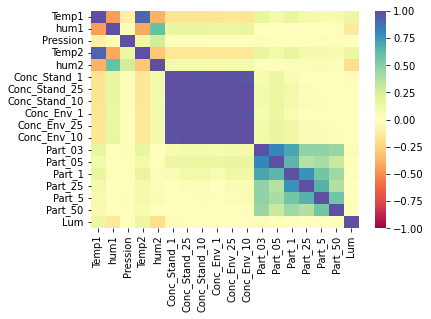

In [4]:
# Correlation matrix
corr = data.drop(columns=['id']).corr()
sns.heatmap(corr, cmap='Spectral', center=0, vmax=1., vmin=-1.)

Our inexperienced student thinks all is fine and takes this results as solid evidence-based truth. 

However, some of these correlations (or lack thereof) are rather surprising. In particular, pay attention to the atmospheric pression. According to this analysis, it does not present high correlations with any other variable, including temperature and humidity. 

Let's take a look at the pression time series:

In [5]:
data['time'] = pd.to_datetime(data.time)
px.line(data, x='time', y='Pression')

You can see there are clear outliers, possibly caused by some sensor malfunction. If you continue to explore the data, you will encounter similar problems with the timeseries from other sensors.


## Objective
This activity is an evaluation element of the skill 
> Evaluate the statistical bias to present the cost/benefit tradeoff of Data Cleaning

Your general goal is to present the importance of the cleaning process to the validity of a data analysis.
To fulfill this goal, you will focus on the variable `Pression`. Show that it's lack of correlation with the temperature and humidity sensors is wrongly deduced because of the presence of outliers. 

1. Pick a simple but suitable method to remove these outliers (try winsorizing or cliping and replacing with na).
1. Try different methods of filling the NA values (backfill, interpolate, etc.)
1. Compare descriptive statistics of the pression series before and after each cleaning step.
1. Compare correlations using the original series and using the different versions of the clean series.

You may then pursue your analysis by cleaning other variables in order to obtain a more meaningful correlation analysis. To limit the duration of this activity, you may restrain your analysis to the variables involving pressure, temperature and humidity.

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3036 entries, 0 to 3035
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             3036 non-null   int64  
 1   time           3036 non-null   object 
 2   Temp1          3036 non-null   float64
 3   hum1           3036 non-null   float64
 4   Pression       3036 non-null   float64
 5   Temp2          3036 non-null   float64
 6   hum2           3036 non-null   float64
 7   Conc_Stand_1   3036 non-null   int64  
 8   Conc_Stand_25  3036 non-null   int64  
 9   Conc_Stand_10  3036 non-null   int64  
 10  Conc_Env_1     3036 non-null   int64  
 11  Conc_Env_25    3036 non-null   int64  
 12  Conc_Env_10    3036 non-null   int64  
 13  Part_03        3036 non-null   int64  
 14  Part_05        3036 non-null   int64  
 15  Part_1         3036 non-null   int64  
 16  Part_25        3036 non-null   int64  
 17  Part_5         3036 non-null   int64  
 18  Part_50 

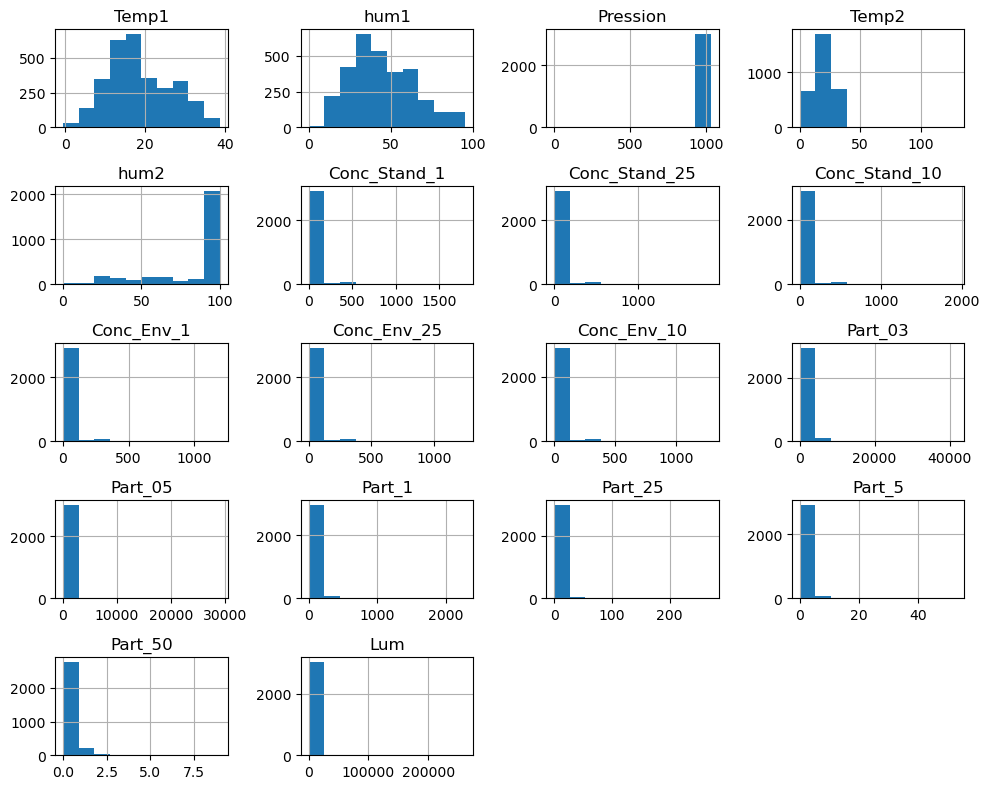

In [52]:
data.drop(columns=['id', 'time']).hist(figsize=(10,8));
plt.tight_layout()

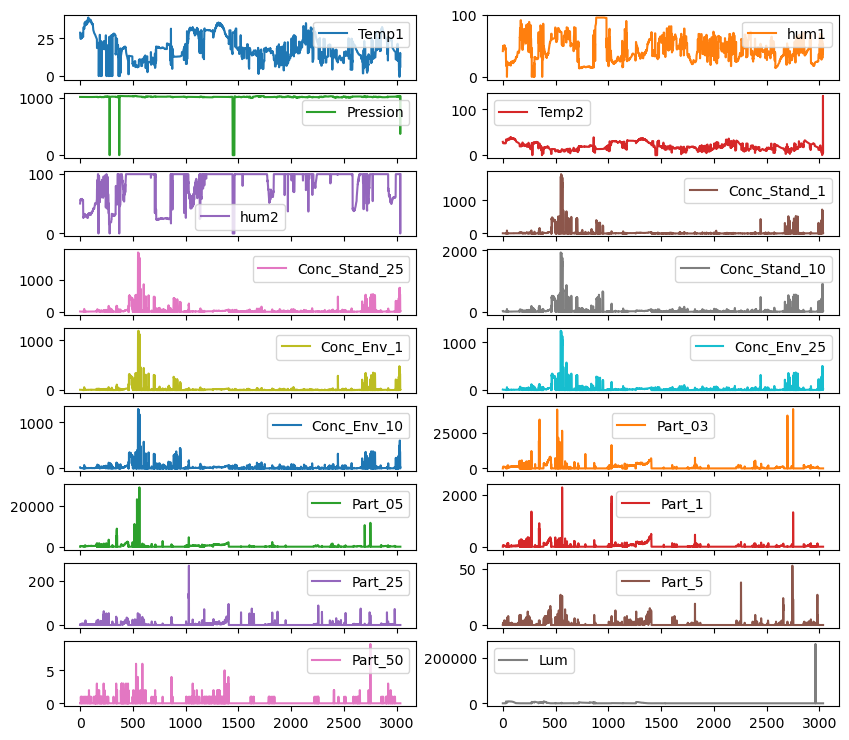

In [53]:
data.drop(columns=['id', 'time']).plot(subplots=True, figsize=(10,10), layout=(10, 2));

In [55]:
# Creating a copy of the dataframe to work on
clean_data = data.copy(deep=True)

## Case study 1: Pression

In [56]:
corr.Pression

Temp1           -0.094388
hum1             0.051350
Pression         1.000000
Temp2            0.133911
hum2             0.263297
Conc_Stand_1     0.028742
Conc_Stand_25    0.026628
Conc_Stand_10    0.026882
Conc_Env_1       0.029702
Conc_Env_25      0.026857
Conc_Env_10      0.027206
Part_03          0.032111
Part_05          0.024982
Part_1           0.027662
Part_25          0.024681
Part_5           0.031386
Part_50          0.026522
Lum              0.007877
Name: Pression, dtype: float64

In [57]:
px.line(data, x='time', y='Pression')

In [58]:
px.box(data, x='Pression')

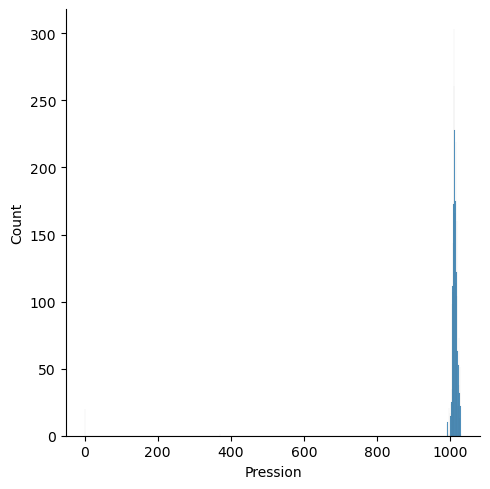

In [59]:
sns.displot(data, x='Pression')

In [60]:
data.Pression.describe()

count    3036.000000
mean     1006.951647
std        83.064496
min         0.000000
25%      1010.217500
50%      1013.135000
75%      1017.592500
max      1030.880000
Name: Pression, dtype: float64

In [124]:
Q1, Q3 = data.Pression.describe()[['25%', '75%']]
IQR= Q3-Q1
k=1.5

pression = pd.DataFrame({
    'original': data.Pression,
    'time': data.time,
    f'winsorized k={k}': data.Pression.clip(lower=Q1-k*IQR, upper=Q3+k*IQR),
    f'NA k={k}': data.Pression.mask(data.Pression < (Q1-k*IQR)).mask(data.Pression >Q3+k*IQR),
    })

pression['NA+backfill'] = pression[f'NA k={k}'].fillna(method='bfill')
pression['NA+interpolate'] = pression[f'NA k={k}'].interpolate(method='linear')

px.box(pression, x=pression.columns.drop('time'))


In [125]:
pression.describe()

,original,winsorized k=1.5,NA k=1.5,NA+backfill,NA+interpolate
count,3036.000000,3036.000000,2947.000000,3036.000000,3036.000000
mean,1006.951647,1013.794672,1014.006559,1013.994529,1013.969929
std,83.064496,6.025428,5.552671,5.805341,5.664900
min,0.000000,999.155000,1000.500000,1000.500000,1000.500000
25%,1010.217500,1010.217500,1010.460000,1010.387500,1010.390000
50%,1013.135000,1013.135000,1013.200000,1013.200000,1013.180000
75%,1017.592500,1017.592500,1017.590000,1017.822500,1017.682500
max,1030.880000,1028.655000,1028.080000,1028.080000,1028.080000


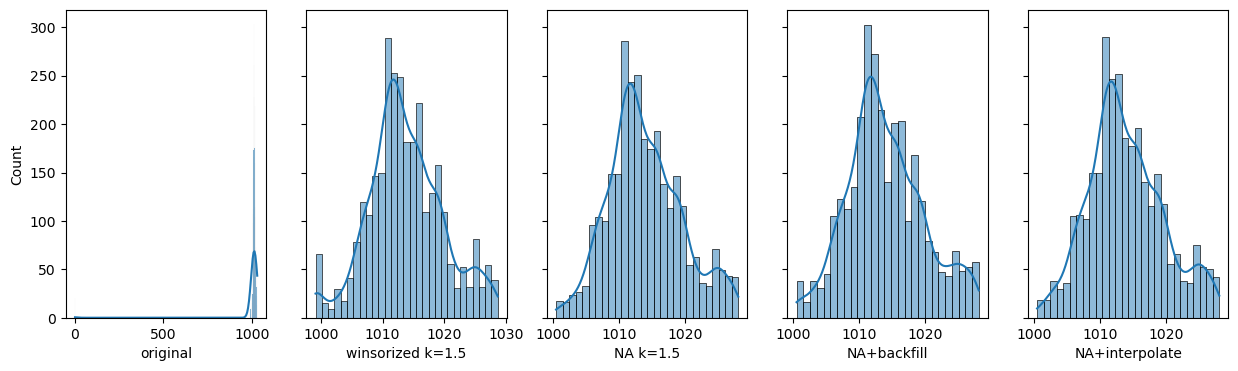

In [126]:
fig, axs = plt.subplots(1, pression.shape[1]-1, figsize=(15,4), sharey=True)
for i, col in enumerate(pression.drop('time',axis=1)):
        sns.histplot(pression, x=col, ax=axs[i], kde=True)


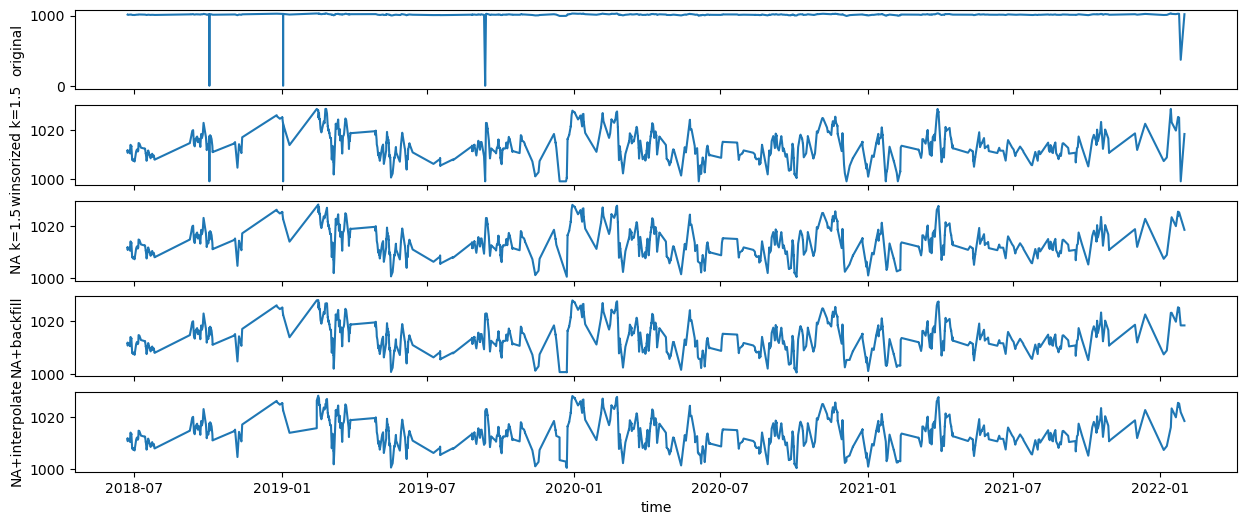

In [127]:
fig, axs = plt.subplots(pression.shape[1]-1, 1, figsize=(15,6), sharex=True)
for i, col in enumerate(pression.drop('time',axis=1)):
        sns.lineplot(data=pression, x='time', y=col, ax=axs[i])


<AxesSubplot:>

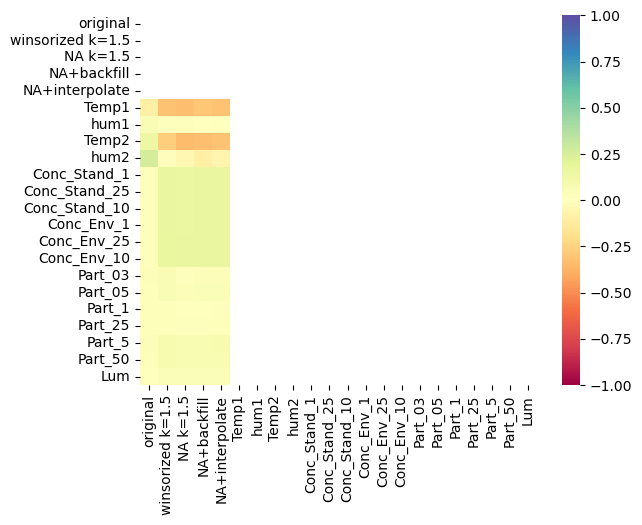

In [155]:
df_corr = pd.concat([pression, data.drop(columns=['id','time', 'Pression'])], axis=1)
corr_ps = df_corr.corr()
mask = np.ones_like(corr_ps)
mask[pression.shape[1]-1:,:pression.shape[1]-1 ] = 0
sns.heatmap(corr_ps, mask=mask, cmap='Spectral', center=0, vmax=1., vmin=-1.)


<AxesSubplot:>

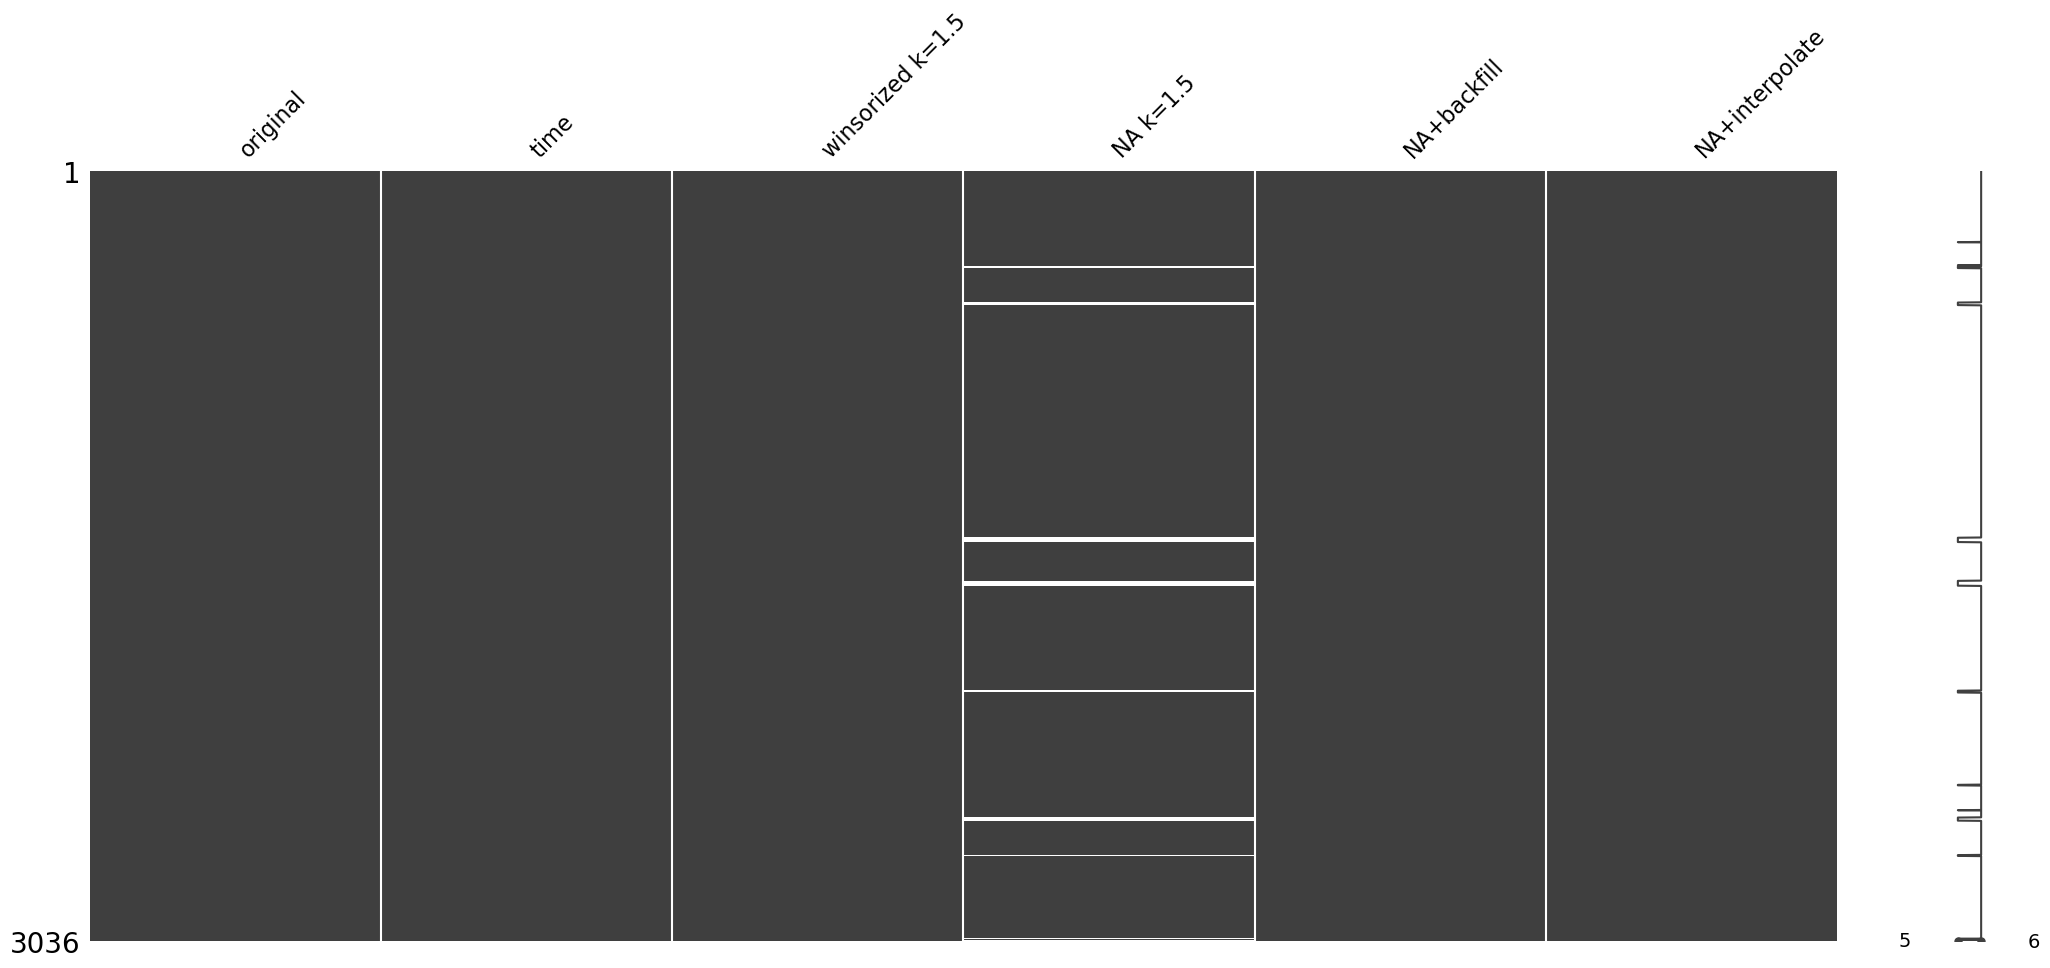

In [138]:
msno.matrix(pression)